In [1]:
###############################
# Import the necessary modules
###############################

# The PyBullet physics simulation library
import pybullet as p
import pybullet_data

# Numpy for numerical calculations and manipulations
import numpy as np
import math

# Matplotlib to create the necessary plots
import matplotlib.pyplot as plt

In [2]:
#################################################################
# Forward and Inverse kinematics modules for the serial-2R robot
#################################################################

def forward_kinematics(theta1, theta2, l1, l2):
    '''
    Forward kinematics module for a serial-2R chain.
    The base of the manipulator is assumed to be placed at the
    coordinates [0,0].
    All the joints allow rotation about the positive Z-axis.
    Args:
    --- theta1: Angle between the link l1 and the positive x-axis (in radians)
    --- theta2: Relative angle between link l1 and link l2 (in radians)
    --- l1: Length of link l1 (in m)
    --- l2: Length of link l2 (in m)
    Ret:
    --- [x, y]: Position co-ordinates of the end-effector (in m)
    '''
    x = l1*math.cos(theta1) + l2*math.cos(theta1 + theta2)
    y = l1*math.sin(theta1) + l2*math.sin(theta1 + theta2)
    return [x, y]

def inverse_kinematics(x, y, l1, l2, branch=1):
    '''
    Inverse kinematics modules for the serial-2R manipulator.
    The base of the manipulator is placed at [0,0].
    Axis of rotation is the Z+ axis.
    Args:
    --- x : X co-ordinate of the end-effector
    --- y : Y co-ordinate of the end-effector
    --- l1: Length of link l1
    --- l2: Length of link l2
    --- branch: Branch of the inverse kinematics solution.
    Ret:
    --- valid: Binary variable indicating if the solution is valid or not
    --- [theta1, theta2]: Angles made by link l1 w.r.t X+ axis and the relative
                    angle between links l1 and l2 respectively.
    '''
    a = 2*x*l2
    b = 2*y*l2
    c =  l1*l1 - x*x - y*y  - l2*l2 
    psi = math.atan2(b, a)
    d = -c/math.sqrt(a*a + b*b)
    
    if (d < -1) or (d > 1):
        print("Position out of workspace.")
        return False, [0,0]
    if branch == 1:
        theta12 = psi + math.acos(-c/math.sqrt(a*a + b*b))
    else:
        theta12 = psi - math.acos(-c/math.sqrt(a*a + b*b))
        
    theta1 = math.atan2((y - l2*math.sin(theta12))/l1, (x - l2*math.cos(theta12))/l1)
    return True, [theta1, theta12-theta1]

In [3]:
##############################################################
# Create an instance of the Physics Server and connect to it
##############################################################

# Use p.DIRECT to connect to the server without rendering a GUI
# Use p.GUI to create a GUI to render the simulation
client = p.connect(p.GUI) # or p.GUI


# Load the URDF of the plane that forms the ground
p.setAdditionalSearchPath(pybullet_data.getDataPath()) # Set the search path to find the plane.urdf file
plane = p.loadURDF("plane.urdf")


# Load the URDF of the robot
robot = p.loadURDF("planar_2R_robot.urdf")

In [4]:
##################################################
# Set the necessary parameters for the simulation
##################################################

# Set the Gravity vector
p.setGravity(0,0,-9.81, physicsClientId = client)

# Set the simulation time-step
p.setTimeStep(0.001) #The lower this is, more accurate the simulation 

# You can be faster than real-time if you choose
#p.setRealTimeSimulation(0)  # we want to be faster than real time.

In [5]:
#################################
# Enable the motors on the joints 
#################################

# This step is required to enable torque control. Refer to the documentation for more details.
p.setJointMotorControl2(robot, 1, p.VELOCITY_CONTROL, force=0)
p.setJointMotorControl2(robot, 2, p.VELOCITY_CONTROL, force=0)

In [6]:
################################################################################
# Create a Proportional control loop to regulate the position of a single joint
################################################################################

# Define a sinusoidal trajectory
dt     = 0.001 # Simulation time-step
f      = 1.0 # Frequency of oscillation (1 Hz)
omega  = 2*math.pi*f # Angular frequency
theta0 = 0 # Start position
p_des = np.zeros(10000)
for i in range(10000):
    t = i*dt
    p_des[i] = np.sin(theta0 + omega*t)


    

p_gain = 1000 # Proportional gain
d_gain = 500 # Derivative gain

error = 0
error_old = 0

pos1 = []
cf = []

# Run the control loop
for i in range(10000):
    
    # Get the joint state
    p_act, _, _, _ = p.getJointState(robot, 1)
    
    # Calculate the control input
    error_old = error
    error = p_des[i] - p_act
    error_d = (error - error_old)/dt
    control_force = p_gain * error + d_gain * error_d # PD control
    control_force = np.clip(control_force, -50, 50) # Saturation; to model the torque limit of the motors
    
    # Run the simulation for one time-step
    p.setJointMotorControl2(robot, 1, p.TORQUE_CONTROL, force=control_force)
    p.stepSimulation()
    
    # Store the data for plotting
    pos1.append(p_act)
    cf.append(control_force)
    

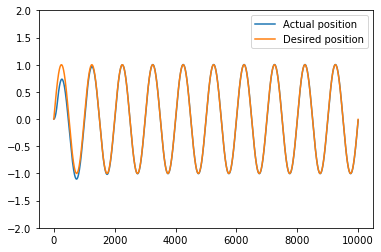

In [7]:
################
# Plot the data
################
plt.figure(2)
plt.plot(pos1, label="Actual position")
plt.plot(p_des, label="Desired position")
plt.ylim([-2,2])
#plt.plot(cf, label="Control Input")
plt.legend()
plt.show()

In [8]:
##########################################################
# Reach a specified point in the task-space of the robot
##########################################################


# Kinematics for serial-2R
p1 = np.array([1.0, 0.5])
p2 = np.array([0.5, 1.0])
pt_des = p1 # or p2

valid, [theta1, theta2] = inverse_kinematics(pt_des[0], pt_des[1], 1, 1)


dt     = 0.001 # simulation time-step
p_gain = 200 # Proportional gain
d_gain = 50 # Derivative gain
error  = 0
error_old = 0
desired_pos = np.array([theta1, theta2])
for _ in range(1000):
    pos1, _, _, _ = p.getJointState(robot,1)
    pos2, _, _, _ = p.getJointState(robot,2)
    pos = np.array([pos1, pos2])
    error_old = error
    error = desired_pos - pos
    error_d = (error - error_old)/dt
    control_force = p_gain * error + d_gain * error_d
    p.setJointMotorControlArray(robot, [1,2], p.TORQUE_CONTROL, forces=control_force)
    p.stepSimulation()

    
# Check if the robot has reached the desired position
pos1, _, _, _ = p.getJointState(robot, 1)
pos2, _, _, _ = p.getJointState(robot, 2)
pt_act = forward_kinematics(pos1, pos2, 1, 1)

print(pt_des)
print(pt_act)

[1.  0.5]
[1.0460882504484459, 0.4700223903469647]
